In [ ]:
from os import path
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


앞선 doc2vec 은 효준이가 명사, 형용사, 동사만 추출한 것을 임베딩 한 것. 

이번 doc2vec2은 효준이가 서술어까지 전부 해서 추출한 것을 임베딩 할 것. 


앞서 size 50, epoch 300을 해서 랜포로 성능시험을 하였음.

이번에도 동일하게 먼저 수행하여 과연 성능 향상이 있을지를 평가하겠음. 


이후에 앞선 데이터와 현재 데이터를 가지고 size, epoch, window size, SVM, LSTM등 다양하게

시도하여 성능을 산출할 예정 

# 1. 사용 library

In [ ]:
import pandas as pd
import numpy as np
import gensim

# 2. 데이터 불러오기


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/w2v_colab/0527naver_real_estate_hangul.csv')

In [ ]:
raw_data.head()

,Unnamed: 0,month,title,text,new_token,hangul,spi,spi_updown
0,0,201101,"소득 안늘고 집값은 비싸 “뾰족수 없네”,전세대란에 서민들 눈앞이 깜깜한데…'전세금...",[한겨레] [2011년 경제 전망] 부동산시장 침체 벗어날까\n\n부양정책 펴도 반...,/Punctuation 한겨레/Noun /Punctuation /Punctuatio...,한겨레 년 경제 전망 부동산 시장 침체 벗어나다 부양 정책 펴다 반짝 경기...,81.3,1
1,1,201102,"미분양 아파트 61% 중대형,전세가 고공행진에 지방 아파트 매매가도 `꿈틀`,미분양...",전국 미분양 아파트가 감소하는 추세지만 전용면적 85㎡를 초과 하는 중대형 비중은 ...,전국/Noun 미분/Noun 양/Suffix 아파트/Noun 가/Josa 감소/No...,전국 미분 양 아파트 가 감소 하다 추세 지만 전용 면적 를 초과 하다 중대 형...,82.5,1
2,2,201103,"양도세 비과세, 왜 판교만? 일산댁ㆍ분당댁 뿔났다!,고가주택 팔면 일반주택의 13배...",판교는 3.3㎡ 2600만원 이상으로 서울(1800만원 선)보다 집값이 더 비싸다....,판교/Noun 는/Josa 3.3/Number ㎡/Foreign 2600만원/Num...,판교 는 만원 이상 으로 서울 만원 선 보다 집값 이 더 비싸다 하지만 ...,83.4,1
3,3,201104,"[고침]여전히 뜨거운 오피스텔 시장..'수익률' 높은 단지는?,지구지정 백지화…맥빠...",[아시아경제 문소정 기자] (3월31일 16시17분 송고된 '여전히 뜨거운 오피스텔...,/Punctuation 아시아/Noun 경제/Noun 문/Modifier 소정/No...,아시아 경제 문 소정 기자 월 일 시 분 송고된 여전하다 뜨겁다 오피스텔 시...,83.9,1
4,4,201105,"전세대란 속에 서울시는 '재개발 임대 전세금' 폭탄,서울아파트값 두달 연속↓…약세 ...","SH공사, '전세전환이율' 축소…가구당 평균 1000만 원 부담\n\n [프레시안 ...","SH/Alpha 공사/Noun /Punctuation ""/Punctuation"" 전...",공사 전세 전환 이율 축소 가구 당 평균 만 원 부담 프레 시안 허다...,84.1,1


# 3. 전처리


In [ ]:
#raw_data는 너무 거대하니 필요한 부분만 추출
use_data = raw_data[['month','hangul']]

In [ ]:
input_1 = list(use_data['hangul'])

In [ ]:
# 띄워쓰기 별로  슬라이싱
input_2 = [s.lower().strip().split(" ") for s in input_1]

In [ ]:
tagged_documents = []
for i, s in enumerate(input_2):
    tagged_documents.append(
        gensim.models.doc2vec.TaggedDocument(s, [i])
    )

# 4. Doc2Vec 모델 정의/훈련/임베딩확인

In [ ]:
Doc2Vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1)

In [ ]:
Doc2Vec_model.build_vocab(tagged_documents)

In [ ]:
# Doc2Vec 훈련
Doc2Vec_model.train(tagged_documents, total_examples=len(tagged_documents), epochs=300)

In [ ]:
# 모델 저장
Doc2Vec_model.save("d2v_hangul2_size50.model")
!cp d2v_hangul2_size50.model '/content/drive/MyDrive/w2v_colab/'
## Load saved doc2vec model
# Doc2Vec_model= Doc2Vec.load("/content/drive/MyDrive/w2v_colab/d2v_hangul2_size50.model")

In [ ]:
#각 월의 벡터들을 데이터 프레임 형태로 변환
vectorized = []
for i in range(120):
    vectorized.append(Doc2Vec_model.docvecs[i])
vectorized_df = pd.DataFrame(vectorized)

In [ ]:
vectorized_df.to_csv('d2v_hangul2_size50_vector.csv')
!cp d2v_hangul2_size50_vector.csv '/content/drive/MyDrive/w2v_colab'

#load vectors
#vectorized_df = pd.read_csv('/content/drive/MyDrive/w2v_colab/d2v_hangul2_size50_vector.csv')

# 5. 임베딩 이후 분류기 생성(분류기쪽 돌려볼 사람들은  1번 이후 바로 여기서부터 하면 됨)

In [ ]:
vectorized_df = pd.read_csv('/content/drive/MyDrive/w2v_colab/d2v_hangul2_size50_vector.csv')
vectorized_df.drop(['Unnamed: 0'], axis =1, inplace = True)

In [ ]:
vectorized_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.035802,0.762516,0.527483,-0.646350,-0.638488,-0.079218,-2.083597,-1.658492,-0.322451,-0.636430,1.882574,0.574517,1.897205,-0.651150,1.937440,0.620670,-0.057021,-1.217555,-0.045794,1.478200,-2.527859,2.682731,-3.175276,1.270820,-0.686305,0.904846,-1.949708,0.526351,1.419634,-1.350037,0.533267,-0.763875,-1.470060,-1.690300,-0.183936,0.924528,-0.136844,-2.048795,-0.554932,-0.035507,1.848522,-1.940566,0.913441,0.870872,-1.776461,-2.226250,-1.484636,2.031499,0.372622,-1.493396
1,1.211941,1.650563,-0.469811,-0.777811,-2.161437,0.044992,-2.537567,-1.812067,-0.127995,-0.756170,0.980890,2.407633,3.096749,-1.957995,2.765434,1.089077,1.805457,-1.415793,-1.450972,1.052342,-1.289957,1.880963,-2.719432,2.001244,-1.270124,1.048984,-0.560620,0.227437,0.709276,-1.717976,-0.947628,0.789705,-2.107265,-0.770224,1.292593,1.021528,-0.564912,-1.240781,0.010871,0.462850,1.934361,-2.102730,1.586009,1.443880,-3.564772,-1.907247,-1.741129,1.293014,0.715891,-2.572701
2,0.506385,0.007602,0.732889,-1.436335,-1.285927,0.537839,-2.165190,-1.749014,-0.608521,-0.400833,2.278505,1.917514,2.766977,-0.605020,1.587873,1.501726,0.378449,-0.783849,-0.165438,0.442723,-1.498136,1.568732,-3.438475,1.602641,-0.217831,0.907915,-1.849688,0.679552,0.274638,-0.815773,0.889303,-1.697673,-0.520854,-0.518915,0.483085,-0.172558,-0.901810,-1.682845,0.417701,-0.572933,0.648301,-3.478572,0.644871,0.667437,-1.992249,-1.717071,-1.175113,2.171807,-0.981696,-2.434427
3,0.421672,1.788684,-0.630690,-1.931314,-0.861619,0.104236,-3.292149,-1.404057,0.332171,-1.882838,3.287694,2.329005,1.208425,-1.345285,-0.107846,0.982285,0.927584,-1.454931,-1.531943,1.584144,-2.517164,0.621538,-3.112977,0.818314,-0.888132,0.185689,-0.945793,0.310528,2.194615,-2.355299,-0.302270,-0.296745,-1.765710,-1.846714,-1.037139,0.517816,-1.178245,-1.741825,-0.441724,-0.294710,0.774997,-1.427108,1.165789,1.311348,-3.870947,-0.429112,-2.529389,3.050401,-1.300192,-1.808842
4,0.270021,-0.209075,-0.901358,0.285627,-0.542318,0.472183,-2.817194,-2.276740,-1.477996,-0.654881,1.787736,1.187577,2.351966,-1.279965,1.292234,1.045684,-0.587314,-1.265235,-0.164149,-0.600626,-2.947251,1.834483,-2.233190,2.108989,-0.045028,1.536766,-2.275047,-0.562577,0.158143,-1.514790,0.586937,-0.590661,-0.807100,-1.498084,-1.077217,0.099772,-0.948838,-2.172785,0.619164,0.664175,1.054428,-1.945660,1.177727,0.758570,-2.518123,-1.374402,-0.672027,1.948901,-0.359897,-1.588454


In [ ]:
before_df = pd.read_csv('/content/drive/MyDrive/w2v_colab/0507 df_for_holdout_utf.csv')

In [ ]:
spi_df = before_df['spi']

In [ ]:
whole_data = pd.concat([vectorized_df, spi_df], axis = 1)

In [ ]:
whole_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,spi
0,-0.035802,0.762516,0.527483,-0.646350,-0.638488,-0.079218,-2.083597,-1.658492,-0.322451,-0.636430,1.882574,0.574517,1.897205,-0.651150,1.937440,0.620670,-0.057021,-1.217555,-0.045794,1.478200,-2.527859,2.682731,-3.175276,1.270820,-0.686305,0.904846,-1.949708,0.526351,1.419634,-1.350037,0.533267,-0.763875,-1.470060,-1.690300,-0.183936,0.924528,-0.136844,-2.048795,-0.554932,-0.035507,1.848522,-1.940566,0.913441,0.870872,-1.776461,-2.226250,-1.484636,2.031499,0.372622,-1.493396,82.5
1,1.211941,1.650563,-0.469811,-0.777811,-2.161437,0.044992,-2.537567,-1.812067,-0.127995,-0.756170,0.980890,2.407633,3.096749,-1.957995,2.765434,1.089077,1.805457,-1.415793,-1.450972,1.052342,-1.289957,1.880963,-2.719432,2.001244,-1.270124,1.048984,-0.560620,0.227437,0.709276,-1.717976,-0.947628,0.789705,-2.107265,-0.770224,1.292593,1.021528,-0.564912,-1.240781,0.010871,0.462850,1.934361,-2.102730,1.586009,1.443880,-3.564772,-1.907247,-1.741129,1.293014,0.715891,-2.572701,83.4
2,0.506385,0.007602,0.732889,-1.436335,-1.285927,0.537839,-2.165190,-1.749014,-0.608521,-0.400833,2.278505,1.917514,2.766977,-0.605020,1.587873,1.501726,0.378449,-0.783849,-0.165438,0.442723,-1.498136,1.568732,-3.438475,1.602641,-0.217831,0.907915,-1.849688,0.679552,0.274638,-0.815773,0.889303,-1.697673,-0.520854,-0.518915,0.483085,-0.172558,-0.901810,-1.682845,0.417701,-0.572933,0.648301,-3.478572,0.644871,0.667437,-1.992249,-1.717071,-1.175113,2.171807,-0.981696,-2.434427,83.9
3,0.421672,1.788684,-0.630690,-1.931314,-0.861619,0.104236,-3.292149,-1.404057,0.332171,-1.882838,3.287694,2.329005,1.208425,-1.345285,-0.107846,0.982285,0.927584,-1.454931,-1.531943,1.584144,-2.517164,0.621538,-3.112977,0.818314,-0.888132,0.185689,-0.945793,0.310528,2.194615,-2.355299,-0.302270,-0.296745,-1.765710,-1.846714,-1.037139,0.517816,-1.178245,-1.741825,-0.441724,-0.294710,0.774997,-1.427108,1.165789,1.311348,-3.870947,-0.429112,-2.529389,3.050401,-1.300192,-1.808842,84.1
4,0.270021,-0.209075,-0.901358,0.285627,-0.542318,0.472183,-2.817194,-2.276740,-1.477996,-0.654881,1.787736,1.187577,2.351966,-1.279965,1.292234,1.045684,-0.587314,-1.265235,-0.164149,-0.600626,-2.947251,1.834483,-2.233190,2.108989,-0.045028,1.536766,-2.275047,-0.562577,0.158143,-1.514790,0.586937,-0.590661,-0.807100,-1.498084,-1.077217,0.099772,-0.948838,-2.172785,0.619164,0.664175,1.054428,-1.945660,1.177727,0.758570,-2.518123,-1.374402,-0.672027,1.948901,-0.359897,-1.588454,84.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2.509685,-0.362866,-1.112325,-0.981170,-1.802777,2.584458,-1.015257,-2.377328,-1.626601,-0.011455,2.951705,5.013472,7.012151,-0.712439,-0.002054,0.872842,-1.392580,0.782678,2.017218,-1.271523,-3.841493,2.275810,-3.687452,0.614565,-1.299010,0.372624,0.112713,0.977223,2.136868,-0.935083,2.407025,-1.681651,-5.574606,-1.611528,0.142155,-0.031791,-1.424852,-3.973725,-0.130292,-0.593422,-0.175813,-3.503652,5.292339,1.641297,-2.330398,-1.575629,0.733557,-0.779655,-0.203635,-0.212297,114.0
116,1.672343,-0.334270,-0.922863,-0.092252,0.304882,1.358173,-0.187025,-2.872575,0.491301,-1.261173,1.016735,3.309492,5.066948,2.179821,0.506294,0.399411,-0.607002,1.774560,1.928474,-0.777583,-3.588605,2.791864,-4.002852,0.255036,-3.951135,1.245576,0.390608,0.036360,1.091432,-0.266250,2.716283,0.094167,-4.623162,-2.405396,0.144613,-1.103741,-0.905605,-2.991017,1.849764,-0.712494,1.344147,-0.358958,3.234710,1.057553,-2.119385,0.152683,-0.343579,0.184961,-0.597110,-1.758648,115.6
117,2.514826,0.905083,-1.432545,-0.624301,-1.217057,1.171032,-0.787166,-1.211160,1.786186,-3.534185,1.690424,3.025398,4.975113,4.115765,0.964698,-1.830588,-0.719688,4.100430,1.443791,-0.738610,-0.256533,3.235024,-4.559209,3.338443,-5.558913,2.536

## 5.1 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
train = whole_data[:90]
test = whole_data[90:]
X_train = train.drop(['spi'], axis = 1)
X_test = test.drop(['spi'], axis = 1)
y_train = train['spi']
y_test = test['spi']

In [ ]:
regressor = RandomForestRegressor(n_estimators = 20, random_state = 0)
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
rmse

10.498324945755233

## 5.2 SVM 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [ ]:
# SVM 인풋 데이터 스케일링
sc = StandardScaler()
X_train_basic_svm = sc.fit_transform(X_train)
X_test_basic_svm = sc.transform(X_test)

In [ ]:
score_list = []

In [ ]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf','sigmoid']} 
  
grid_svm = GridSearchCV(SVR(), param_grid_svm, refit = 'mse', verbose = 0, cv = 5)

# fitting the model for grid search
grid_svm.fit(X_train_basic_svm, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit='mse', return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
y_pred = grid_svm.predict(X_test_basic_svm)
RMSE = mean_squared_error(y_test, y_pred)**0.5

# RMSE 출력
print(RMSE)

score_list.append(('거시경제',RMSE))
# print best parameter after tuning
print(grid_svm.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_svm.best_estimator_)

13.601092885848058
{'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


## 5.3 XGB Regressor

In [ ]:
from xgboost import XGBRegressor

In [ ]:
score_list=[]

In [ ]:

from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
        'n_estimators' : [50, 100, 150, 200],
        'gamma': [0.3, 0.6, 0.9, 1.2, 1.5],
        'subsample' : [i/10.0 for i in range(6,11)],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7, 9]
        }
  
grid_XGBR = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid, refit = 'mse', verbose = 0, cv = 5)

# fitting the model for grid search
grid_XGBR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...mbda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.3, 0.6, 0.9, 1.2, 1.5],
         

In [ ]:
y_pred = grid_XGBR.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5

# RMSE 출력
print(RMSE)
score_list.append(('거시경제',RMSE))
# print best parameter after tuning
print(grid_XGBR.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_XGBR.best_estimator_)

12.469393350922589
{'colsample_bytree': 1.0, 'gamma': 0.9, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.9,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)


## RNN


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train_dataset = X_train_basic_svm.copy()
test_dataset = X_test_basic_svm.copy()

In [ ]:
train_dataset.shape[1]

50

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[train_dataset.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
rnn_model = build_model()

In [ ]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 79,105
Trainable params: 79,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

### early stopping 없이

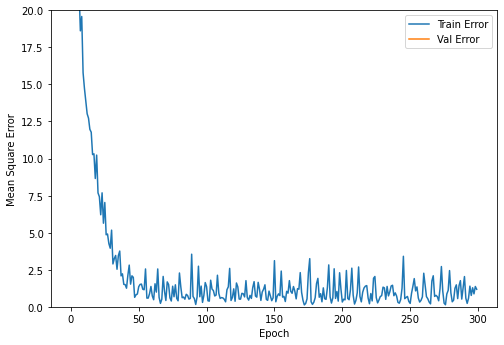

In [ ]:
EPOCHS = 300
history = rnn_model.fit(
  train_dataset, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

plot_history(history)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,0.768508,0.738670,0.768508,729.434998,24.149920,729.434998,295
296,1.283869,0.993639,1.283869,699.307495,23.773014,699.307495,296
297,0.872563,0.838373,0.872563,699.288330,23.806770,699.288330,297
298,1.370244,1.010108,1.370244,685.816101,23.555067,685.816101,298
299,1.181740,0.858654,1.181740,725.916260,24.172974,725.916260,299


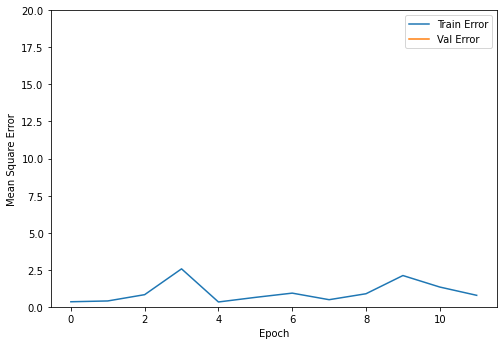

In [ ]:
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000
history = rnn_model.fit(train_dataset, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

In [ ]:
np.asarray(y_test)

array([101.2, 102.6, 102.9, 102.2, 101.5, 101. , 100.6,  99.9,  99.6,
        99.5,  99.8, 100.2, 100.5, 100.9, 101.4, 102.3, 103.3, 104. ,
       105.4, 106.3, 106.3, 107.1, 109.2, 111.6, 113.1, 114. , 115.6,
       118.3, 121.4, 124.9])

In [ ]:
## Test set
loss, mae, mse = rnn_model.evaluate(test_dataset,np.asarray(y_test) , verbose=2)

1/1 - 0s - loss: 575.3708 - mae: 19.1989 - mse: 575.3708


In [ ]:
y_pred = rnn_model.predict(test_dataset)

In [ ]:
y_pred

array([[ 76.82138 ],
       [ 58.83895 ],
       [ 62.555584],
       [ 44.36261 ],
       [ 66.18999 ],
       [ 61.174526],
       [ 78.43907 ],
       [ 84.2825  ],
       [ 76.129265],
       [ 90.08513 ],
       [110.34833 ],
       [ 87.86975 ],
       [ 88.03537 ],
       [ 91.430244],
       [ 85.27878 ],
       [ 80.74272 ],
       [133.36497 ],
       [125.40589 ],
       [ 84.65138 ],
       [115.194336],
       [107.11536 ],
       [134.4985  ],
       [115.91319 ],
       [117.74364 ],
       [112.25927 ],
       [112.956085],
       [111.249344],
       [155.68098 ],
       [122.33124 ],
       [110.27871 ]], dtype=float32)

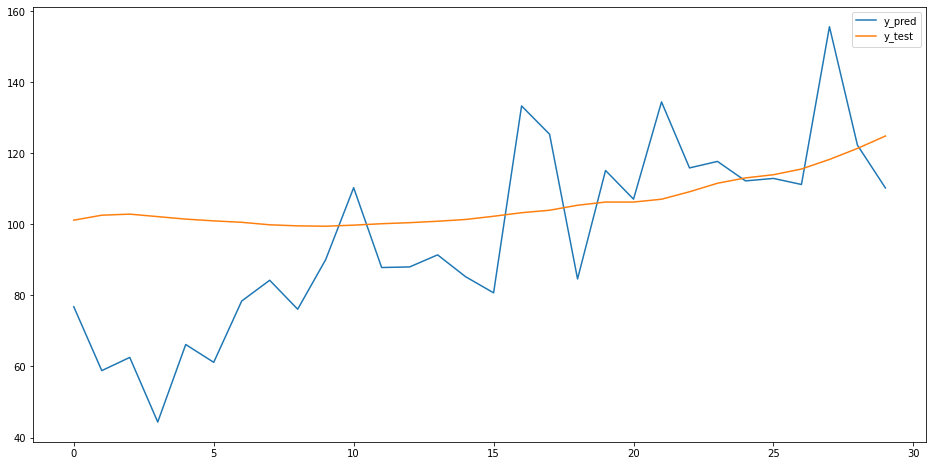

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_pred)
plt.plot(list(y_test))
plt.legend(['y_pred', 'y_test'])